In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.stats as sts

In [2]:
def read_reference_energies():
    folders = glob.glob('naphtalene/validation-molpro/*/')
    res = []
    for folder in folders:
        this = {}
        
        basename = folder.split('/')[-2]
        this['label'] = basename.split('-')[-1]
        this['nbn'] = int(basename.split('-')[1])
        
        try:
            with open(folder+ 'direct.out') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-6].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear energy' in _][0].strip().split()[-1])
        except:
            with open(folder+ 'run.log') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-7].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear repulsion energy' in _][0].strip().split()[-1])
        
        res.append(this)
    return pd.DataFrame(res)
df = read_reference_energies()

In [12]:
def read_report(fn, restrict):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    started = False
    if restrict is None:
        started = True
    for line in lines:
        # check for relevant section
        if restrict is not None:
            if "stoichiometry" in line:
                nbn = len([_ for _ in line if _ == "5"])
                if nbn == restrict:
                    started = True
                else:
                    started = (restrict is None)
        if not started:
            continue
        if "Found:" in line:
            label = ''.join(line.split('[')[1].split(']')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]
#read_report('napthalene-molpro.report')

5
4
3
2
1


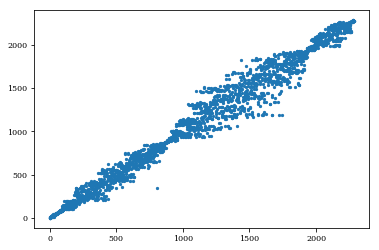

In [180]:
def visualise_report(fn, df):
    report, groups = read_reranked_report(fn,  COEFFS)
    df = df.query("nbn > 0").sort_values('energy')
    actual = [report.index(_.replace('5', 'B').replace('6', 'C').replace('7', 'N')) for _ in df.label.values]
    
    #bars = np.cumsum(groups)
    #for bar in bars:
    #    plt.axhline(bar, 0.99)
    plt.scatter(range(len(actual)), actual, s=5)
    
    width = 3.5
    height = width / 1.618
    f.tight_layout( rect=(-0.05, 0, 0.965, 1.05)) #left, bottom, right, top
    f.set_size_inches(width, height)
    f.savefig('ParameterScan.pdf')
    
#visualise_report('napthalene-molpro-4.5.report', df)
visualise_report('scanning/2.2-CM', df)
#visualise_report('scanning/0.2-ESP', df.query("nbn == 4"))
#visualise_report('napthalene-molpro-nobondcount-2.report', df)
#visualise_report('napthalene-molpro-0.1.report', df)
#visualise_report('napthalene-molpro-0.05.report', df)

In [5]:
def bond_count(label):
    bonds = {'BH': 0, 'CH': 0, 'HN': 0, 'BB': 0, 'BC': 0, 'BN': 0, 'CC': 0, 'CN': 0, 'NN': 0, }
    infile = [(4, 14), (3, 13), (3, 9), (2, 3), (4, 9), (4, 5), (5, 15), (2, 12), (8, 9), (1, 2), (5, 6), (1, 11), (0, 1), (6, 16), (6, 7), (7, 8), (0, 8), (7, 17), (0, 10)]
    for letter in label[:-2]:
        k = ''.join(sorted([letter, "H"]))
        bonds[k] += 1
    
    for a,b in infile:
        if a > 9 or b > 9:
            continue
        k = ''.join(sorted([label[_] for _ in (a, b)]))
        bonds[k] += 1
    return bonds

In [6]:
def ac_bond(df):
    A = np.zeros((len(df), 10))
    b = np.zeros((len(df)))
    #bondorder = sorted(bond_count(df.label.values[0].replace('5', 'B').replace('6', 'C').replace('7', 'N')).keys())
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    print (bondorder)
    for idx, row in df.iterrows():
        counts = bond_count(row.label.replace('5', 'B').replace('6', 'C').replace('7', 'N'))
        A[idx] = [counts[_] for _ in bondorder] + [row.nbn]
        b[idx] = row.energy
    return A, b, np.linalg.lstsq(A, b)[0]

In [25]:
tmp = []
for fn in glob.glob('scanning/*'):
    label = fn.split('/')[1]
    param, method = label.split('-')
    original, improved, ncomponents = rerank(fn, df.query("nbn == 4"), 4)
    tmp.append({'method': method, 'param': float(param), 'components': int(ncomponents), 'original': original, 'improved': improved})
tmp = pd.DataFrame(tmp)

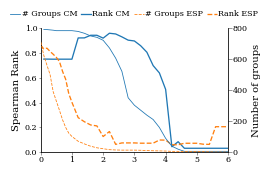

In [146]:
f, ax = plt.subplots(1,1)
plt.rc('font', family='serif')
#plt.rc('xtick', labelsize='8')
#plt.rc('ytick', labelsize='8')

opposite = ax.twinx()

marker = {'CM': '-', 'ESP': '--'}
handles = []
labels= []
for name, group in tmp.sort_values('param').groupby('method'):
    handles += opposite.plot(group.param, group.components.values, marker[name], label='number groups', lw=0.8)
    labels.append('# Groups %s' % name)
    handles += ax.plot(group.param, group.improved, marker[name], label=name, lw=1.3)
    labels.append('Rank %s' % name)
    

ax.tick_params('both', direction='out', labelsize=8, color='grey', pad=1, length=2.5)
opposite.tick_params('both', direction='out', labelsize=8, color='grey', pad=1)

# offset axes
shift = 0
ax.spines['left'].set_position(('outward', shift))
ax.spines['bottom'].set_position(('outward', shift))
ax.spines['left'].set_smart_bounds(True)
opposite.spines['right'].set_smart_bounds(True)
ax.spines['top'].set_visible(False)
opposite.spines['right'].set_position(('outward', shift))

# hide opposite copies of spines
opposite.spines['top'].set_visible(False)
opposite.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
opposite.spines['bottom'].set_visible(False)

# set proper ranges
ax.set_xlim(0, 6)
ax.set_ylim(0, 1)
opposite.set_ylim(0, 800)

# legend and labels
ax.legend(handles, labels, frameon=False, loc='upper left', bbox_to_anchor=(-0.2,0,1,1.2), ncol=4, fontsize=8,handletextpad=0.2, handlelength=1.2,columnspacing=0.5)
ax.set_ylabel('Spearman Rank')
opposite.set_ylabel('Number of groups')

width = 3.5
height = width / 1.618
f.tight_layout( rect=(-0.05, 0, 0.965, 1.05)) #left, bottom, right, top
f.set_size_inches(width, height)
f.savefig('ParameterScan.pdf')

In [155]:
def build_mat(group, bondorder):
    A = []
    for label in group:
        counts = bond_count(label)
        A.append([counts[_] for _ in bondorder])
    return np.array(A)

def solve_group(group, bondorder):
    A = build_mat(group, bondorder)
    if 0 in np.sum(A, axis=0):
        return None
    coeffs = np.linalg.lstsq(A, np.zeros(len(A))+100, rcond=None)[0]
    return coeffs

def rate_coefficients(coeffs, A, b):
    return sts.spearmanr(np.dot(A, coeffs), b).correlation

def rerank(report, df, restrict=4, get_coeffs=False):
    # read groups
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(report, restrict)
    A = build_mat(ranking, bondorder)
    b = []
    bnn = []
    for label in ranking:
        nolabel = label.replace('B', '5').replace('C', '6').replace('N', '7')
        b.append(df.query("label == @nolabel").energy.values[0])# - df.query("label == @nolabel").nn.values[0] )
        bnn.append(df.query("label == @nolabel").nn.values[0] )
    b = np.array(b)
    bnn = np.array(bnn)
    
    # split groups
    groups = []
    modranking = ranking[:]
    for chunk in groupsizes:
        groups.append(modranking[:chunk])
        modranking = modranking[chunk:]
    groups.append(modranking)
        
    # solve each group
    results = []
    sizes = []
    coefficients = []
    for group in groups:
        if len(group) <2:
            continue
        this = solve_group(group, bondorder)
        if this is not None and (this>0).all():
            sizes.append(len(group))
            results.append(rate_coefficients(this, A, b))
            
            # only insert if no duplicate
            for e in coefficients:
                delta = np.linalg.norm(e-this)
                if delta < 1e-10:
                    break
            else:
                coefficients.append(this)
    coeff = -np.array(coefficients).mean(axis=0)
    
    # rerank
    group_energies = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
    
    reranked = []
    for idx in np.argsort(group_energies):
        reranked += groups[idx]
    
    # mix in NN ranking to ensure stability for few groups with valid regressions
    rankNN = np.argsort(bnn)
    newrank = np.array([reranked.index(_) for _ in ranking])
    N = len(coefficients)
    mixed = np.argsort(rankNN/N + newrank * N)
    reranked = [ranking[_] for _ in mixed]    
    
    # calculate original and improved score
    expected = list(df.sort_values("energy").label.str.replace('5', 'B').str.replace('6', 'C').str.replace('7', 'N').values)
    actual1 = [expected.index(_) for _ in ranking]
    xs = list(range(len(actual1)))
    original = sts.spearmanr(xs, actual1).correlation
    #plt.scatter(xs, actual)
    
    actual2 = [expected.index(_) for _ in reranked]
    xs = list(range(len(actual2)))
    improved = sts.spearmanr(xs, actual2).correlation
    
    #plt.scatter(xs, actual)
    
    if get_coeffs:
        return coeff
    return original, improved, len(groups)
COEFFS = rerank('scanning/2.2-CM', df.query("nbn==4"), 4, True)

In [176]:
def read_reranked_report(fn, coeff):
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(fn, None)
    
    # split groups
    groups = []
    gnn = []
    gsize = []
    modranking = ranking[:]
    for chunk in groupsizes:
        gsize.append(chunk)
        groups.append(modranking[:chunk])
        gnn.append(len([_ for _ in modranking[0] if _ == 'B']))
        modranking = modranking[chunk:]
    groups.append(modranking)
        
    # rerank
    group_energies = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
    
    reranked = []
    reranked_sizes = []
    for nbn in sorted(set(gnn))[::-1]:
        print (nbn)
        s = np.where(np.array(gnn) == nbn)[0]
        for idx in np.argsort(np.array(group_energies)[s]):
            reranked += groups[s[idx]]
            reranked_sizes.append(gsize[s[idx]])
    
    return reranked, reranked_sizes
read_reranked_report('scanning/2.2-CM', COEFFS)

5
4
3
2
1


(['BNBNNBNBNB',
  'BNBNBNNBNB',
  'BNBNBNBNBN',
  'BNBNNBBNNB',
  'BBNNNBNBNB',
  'BBNBBNNBNN',
  'BBNBBNBNNN',
  'BBNBNBNBNN',
  'BNBNNBNNBB',
  'BNBNNNBNBB',
  'NBBNNBNNBB',
  'NBBNNBBNBN',
  'BBBNNNNBNB',
  'BNBNNBBNBN',
  'BBNNNBBNNB',
  'BNBNNBNBBN',
  'BBNNNNBBNB',
  'BNNBNBBNBN',
  'BNBNBNNBBN',
  'BBNNBNNBNB',
  'BNNBBNNBBN',
  'BBBNNBNNNB',
  'BBNNBNBNNB',
  'BBNBNNBNNB',
  'BBNBNNNBNB',
  'BBNBNNBNBN',
  'BBNBNBNNBN',
  'BBNBNBNNNB',
  'BBNNBNBNBN',
  'BBNBBNNNBN',
  'BBBNNNBNNB',
  'BBBNBNBNNN',
  'BBBNNBNBNN',
  'BBNBBBNNNN',
  'BBNBNNBBNN',
  'BBBNBNNBNN',
  'BBNBNBBNNN',
  'BBNNNBNNBB',
  'BBNNNNBNBB',
  'BNNNNBBNBB',
  'BNBNBNNNBB',
  'BNNBNBNNBB',
  'BNBNNNNBBB',
  'BBNNNBBNBN',
  'BBNNBBNNBN',
  'BBBNNBNNBN',
  'BBNBBNNNNB',
  'BBNNBNNBBN',
  'BBNBNNNBBN',
  'BBNNNBNBBN',
  'BBBNNNBNBN',
  'BBBNBNNNNB',
  'BBBNBNNNBN',
  'BBBBNBNNNN',
  'BBBNBBNNNN',
  'BBBBBNNNNN',
  'BBBNNNBBNN',
  'BBBNNBBNNN',
  'BBNNNNNBBB',
  'BBNBNNNNBB',
  'BBNNBNNNBB',
  'BBBNNNNNBB',
  'BNNBB